# Sentiment Analysis for Ireland House Rents compared to other countries comment by PM sourced from Reddit API

### Import libraries as needed

In [1]:
#Import libraries as needed 
import praw
import pandas as pd
import numpy as np
import re 
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from praw.models import MoreComments
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import mysql.connector
from pymongo import MongoClient

### Define functions

In [2]:
# Create a function to clean the text
def clean_text(text):
    """
    Clean the text by removing mentions, hashtags, retweets, hyperlinks, and colons.
    
    Parameters:
    text (str): The text to be cleaned.
    
    Returns:
    str: The cleaned text.
    """
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove mentions by replacing them with blank
    text = re.sub(r'#', '', text)  # Remove the '#' symbol by replacing it with blank
    text = re.sub(r'RT[\s]+', '', text)  # Remove retweets by replacing them with blank
    text = re.sub(r'https?:\/\/\S+', '', text)  # Remove hyperlinks
    text = re.sub(r':', '', text)  # Remove colons
    
    return text

# Function to remove emoji and Unicode from the comment data
def remove_emoji(string):
    """
    Remove emoji and Unicode characters from a string.
    
    Parameters:
    string (str): The string to remove emoji and Unicode from.
    
    Returns:
    str: The string without emoji and Unicode characters.
    """
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # Chinese characters
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

# Function to get the subjectivity of a text
def get_subjectivity(text):
    """
    Calculate the subjectivity of a text using TextBlob.
    
    Parameters:
    text (str): The text to calculate subjectivity for.
    
    Returns:
    float: The subjectivity score of the text.
    """
    return TextBlob(text).sentiment.subjectivity

# Function to get the polarity of a text
def get_polarity(text):
    """
    Calculate the polarity of a text using TextBlob.
    
    Parameters:
    text (str): The text to calculate polarity for.
    
    Returns:
    float: The polarity score of the text.
    """
    return TextBlob(text).sentiment.polarity

# Function to group the range of polarity into different categories
def get_insight(score):
    """
    Categorize the polarity score into different insights.
    
    Parameters:
    score (float): The polarity score to categorize.
    
    Returns:
    str: The insight category based on the polarity score.
    """
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"

### Reddit API access setup

In [3]:
#Reddit API credentials to access the the post for Scraping
user_agent = "Reddit_Scrapper 1.0 by /u//suritechie"
reddit = praw.Reddit(
 client_id="d0ymteFirHgy7_4k50jPkw",
 client_secret="6vE-WTaJiLRwiq2u_NDRt8vejncPng",
 user_agent=user_agent
)

### Source Reddit Post & Processing

In [4]:
# Define the URL for the Reddit topic about rents in Ireland commented by Prime Minister in comparison to other countries
input_url = "https://www.reddit.com/r/ireland/comments/108ifhj/taoiseach_leo_varadkar_says_rents_in_ireland_are/"

In [5]:
# Load URL feed using Reddit Submission
submission = reddit.submission(url=input_url)

In [6]:
#Fetch all the post comments into Dataframe
post_comments = []

for comment in submission.comments:
    if type(comment) == MoreComments:
        continue

    post_comments.append(comment.body)

# Create a DataFrame from the comments list
comments_df = pd.DataFrame(post_comments, columns=['comment'])


In [7]:
#Print dataframe to check if comments are collected as needed
comments_df.head(10)

,comment
0,It's almost as if he hasn't been in power for ...
1,Didn’t this bastid say not too long ago “that ...
2,well no fucking shit sherlock....
3,"I'm inspired. This man will deliver, doesn't s..."
4,Finally some common sense from a politician. I...
5,Are Fine Gael not aware that his words have no...
6,I don't think I've ever despised a politician ...
7,"ok great, we're all agreed. Now fucking fix it."
8,"As an innocent bystander in all of this, his ..."
9,Then fucking do something about it


In [8]:
# check total observations or comments gathered for sentiment analysis
len(comments_df)

177

**Selection of Database to store Reddit comments**
Both MongoDB and MySQL are used for programming skills. On factors of Schema Flexiblity, Scalability,performance and Ease of use MongoDB is better choice over MySQL for storing reddit comments to DB. However, both options are explored and used for programming skills

### Option 1: Store the comments in JSON format to MongoDB LocalHost

In [9]:
# Connect to MongoDB
client = MongoClient('localhost', 27017)

# Create or switch to the database
db = client['SentimentAnalysis']

In [10]:
# Drop the collection if it exists
db.redditpost.drop()

# Insert the data into the collection
comment = comments_df['comment'].tolist()
data = [{'comment': comment} for comment in comment]
db.redditpost.insert_many(data)

# Fetch all documents from the collection
reddit_docs = db.redditpost.find()

# Store the fetched data in another dataframe
reddit_df = pd.DataFrame(reddit_docs)

# Close the MongoDB connection
client.close()

# Show the dataframe with the stored comments
reddit_df.head()

,_id,comment
0,6470841195defa01ee3d88fa,It's almost as if he hasn't been in power for ...
1,6470841195defa01ee3d88fb,Didn’t this bastid say not too long ago “that ...
2,6470841195defa01ee3d88fc,well no fucking shit sherlock....
3,6470841195defa01ee3d88fd,"I'm inspired. This man will deliver, doesn't s..."
4,6470841195defa01ee3d88fe,Finally some common sense from a politician. I...


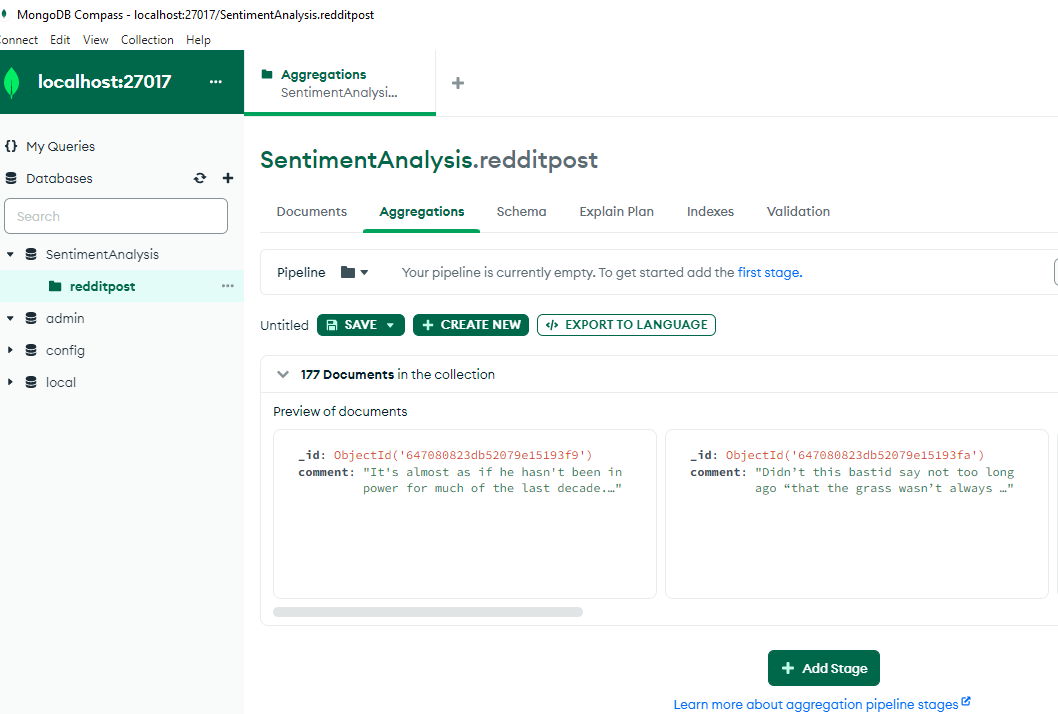

###  Option 2: Store the comments retrieved to MySQL DB on Local Host

In [11]:
# Connect to Localhost MySQL DB
# please update user credentials to run in local host
conn = mysql.connector.connect(
    host='localhost',
    user='user1',
    password='Cctstudent123'
    
)

In [12]:
# Create a database for SentimentAnalysis if not exists
create_db_query = "CREATE DATABASE IF NOT EXISTS SentimentAnalysis"
cursor = conn.cursor()
cursor.execute(create_db_query)

# Switch to the database
conn.database = 'SentimentAnalysis'

# DROP table if  exists 
# This is to avoid Inserting Reddit comments multiple times during code validation
drop_table_query = "DROP TABLE IF EXISTS redditpost"
cursor.execute(drop_table_query)

# Create a table if not exists
create_table_query = "CREATE TABLE IF NOT EXISTS redditpost (comments VARCHAR(10000))"
cursor.execute(create_table_query)

# Insert the data into the table using lambda function

insert_query = "INSERT INTO redditpost (comments) VALUES (%s)"
cursor = conn.cursor()

comments = comments_df['comment'].tolist()
values = list(map(lambda comment: (comment,), comments))

cursor.executemany(insert_query, values)
conn.commit()

# Fetch all rows from the table
fetch_query = "SELECT * FROM redditpost"
cursor.execute(fetch_query)
reddit_rows = cursor.fetchall()

# Store the fetched data in another dataframe
reddit_df = pd.DataFrame(reddit_rows, columns=['comment'])

# Close the database connection
conn.close()
reddit_df.head()

,comment
0,It's almost as if he hasn't been in power for ...
1,Didn’t this bastid say not too long ago “that ...
2,well no fucking shit sherlock....
3,"I'm inspired. This man will deliver, doesn't s..."
4,Finally some common sense from a politician. I...


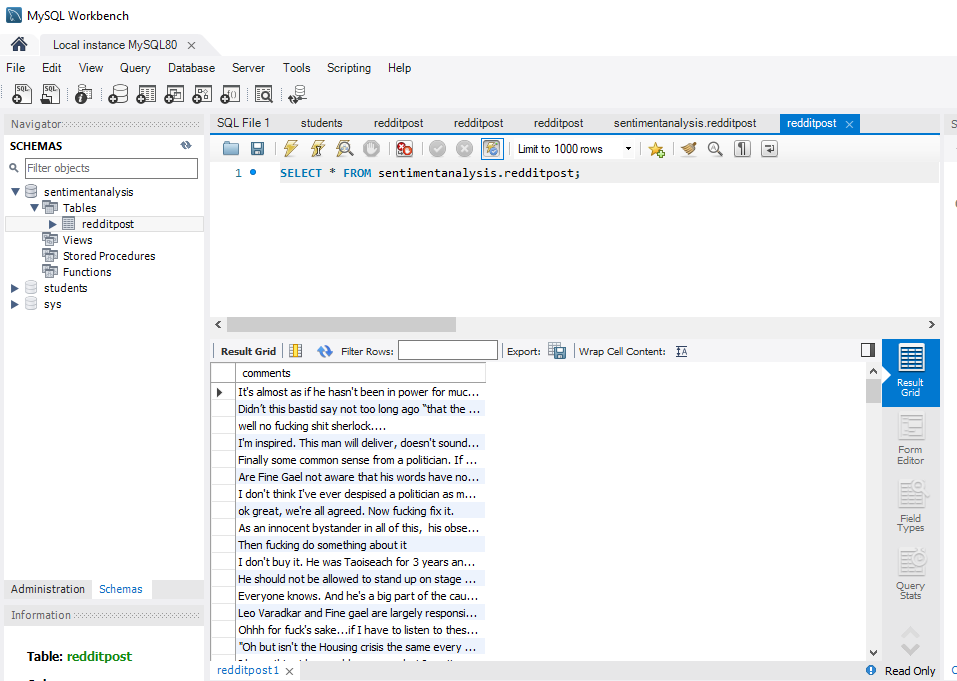

### Data processing & aggregation for Sentiment analysis 

In [13]:
# Clean the text in the 'comment' column of reddit_df
reddit_df['comment'] = reddit_df['comment'].apply(clean_text)

# Show the cleaned text
reddit_df.head()


,comment
0,It's almost as if he hasn't been in power for ...
1,Didn’t this bastid say not too long ago “that ...
2,well no fucking shit sherlock....
3,"I'm inspired. This man will deliver, doesn't s..."
4,Finally some common sense from a politician. I...


In [14]:
# Clean the text in the 'comment' column by removing emoji and Unicode characters
reddit_df['comment'] = reddit_df['comment'].apply(remove_emoji)

# Show the cleaned text
reddit_df.head()


,comment
0,It's almost as if he hasn't been in power for ...
1,Didn’t this bastid say not too long ago “that ...
2,well no fucking shit sherlock....
3,"I'm inspired. This man will deliver, doesn't s..."
4,Finally some common sense from a politician. I...


### Sentiment Analysis for Scores

In [15]:
# Apply the functions to calculate subjectivity and polarity
reddit_df['subjectivity'] = reddit_df['comment'].apply(get_subjectivity)
reddit_df['polarity'] = reddit_df['comment'].apply(get_polarity)

# Show the updated dataframe with subjectivity and polarity columns
reddit_df.head()

,comment,subjectivity,polarity
0,It's almost as if he hasn't been in power for ...,0.133333,0.100
1,Didn’t this bastid say not too long ago “that ...,0.400000,-0.050
2,well no fucking shit sherlock....,0.800000,0.100
3,"I'm inspired. This man will deliver, doesn't s...",0.400000,0.400
4,Finally some common sense from a politician. I...,0.641667,-0.075


In [16]:
# Apply the function to create the 'Insight' column
reddit_df["Insight"] = reddit_df["polarity"].apply(get_insight)

# Show the updated dataframe with the 'Insight' column
reddit_df.head()

,comment,subjectivity,polarity,Insight
0,It's almost as if he hasn't been in power for ...,0.133333,0.100,Positive
1,Didn’t this bastid say not too long ago “that ...,0.400000,-0.050,Negative
2,well no fucking shit sherlock....,0.800000,0.100,Positive
3,"I'm inspired. This man will deliver, doesn't s...",0.400000,0.400,Positive
4,Finally some common sense from a politician. I...,0.641667,-0.075,Negative


In [17]:
# Define the weights for subjectivity and polarity
subjectivity_weight = 0.5
polarity_weight = 0.5

# Calculate the weighted subjectivity score
reddit_df['Weighted_Subjectivity'] = reddit_df['subjectivity'] * subjectivity_weight

# Calculate the weighted polarity score
reddit_df['Weighted_Polarity'] = reddit_df['polarity'] * polarity_weight

# Calculate the overall sentiment score
reddit_df['Overall_Sentiment_Score'] = reddit_df['Weighted_Subjectivity'] + reddit_df['Weighted_Polarity']

# Print the overall sentiment score
overall_sentiment_score = reddit_df['Overall_Sentiment_Score'].mean()
reddit_df.head()

,comment,subjectivity,polarity,Insight,Weighted_Subjectivity,Weighted_Polarity,Overall_Sentiment_Score
0,It's almost as if he hasn't been in power for ...,0.133333,0.100,Positive,0.066667,0.0500,0.116667
1,Didn’t this bastid say not too long ago “that ...,0.400000,-0.050,Negative,0.200000,-0.0250,0.175000
2,well no fucking shit sherlock....,0.800000,0.100,Positive,0.400000,0.0500,0.450000
3,"I'm inspired. This man will deliver, doesn't s...",0.400000,0.400,Positive,0.200000,0.2000,0.400000
4,Finally some common sense from a politician. I...,0.641667,-0.075,Negative,0.320833,-0.0375,0.283333


In [18]:
# Distribution of sentiment scores
sentiment_counts = reddit_df['Insight'].value_counts()
print("Sentiment Distribution:")
print(sentiment_counts)

# Overall sentiment score
average_sentiment_score = reddit_df['Overall_Sentiment_Score'].mean()
print("\nOverall Sentiment Score:", average_sentiment_score)

# Insights based on sentiment
positive_comments = reddit_df[reddit_df['Insight'] == 'Positive']
negative_comments = reddit_df[reddit_df['Insight'] == 'Negative']
neutral_comments =  reddit_df[reddit_df['Insight'] == 'Neutral']

# Example insights
print("\nInsights:")
print("Number of positive comments:", len(positive_comments))
print("Number of negative comments:", len(negative_comments))
print("Number of neutral comments:", len(neutral_comments))
print("Percentage of positive comments:", len(positive_comments) / len(reddit_df) * 100)
print("Percentage of negative comments:", len(negative_comments) / len(reddit_df) * 100)
print("Percentage of neutral comments:", len(negative_comments) / len(reddit_df) * 100)

Sentiment Distribution:
Positive    74
Neutral     58
Negative    45
Name: Insight, dtype: int64

Overall Sentiment Score: 0.20963395402691837

Insights:
Number of positive comments: 74
Number of negative comments: 45
Number of neutral comments: 58
Percentage of positive comments: 41.80790960451977
Percentage of negative comments: 25.423728813559322
Percentage of neutral comments: 25.423728813559322


### Data Visualization of Sentiment Score results

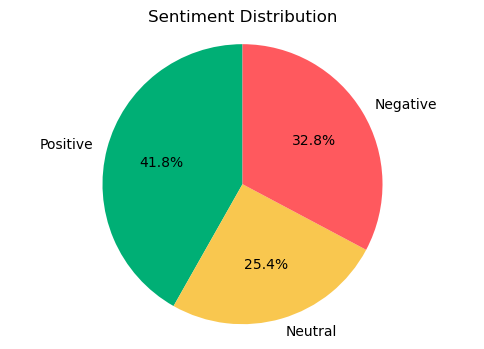

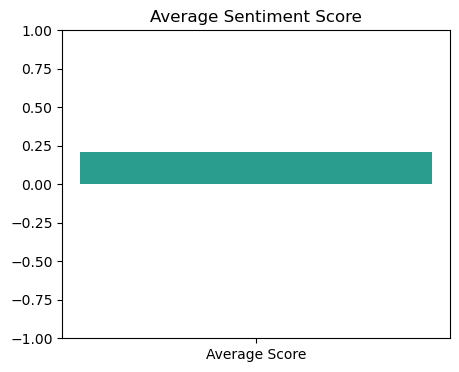

In [19]:
import matplotlib.pyplot as plt

# Sentiment Distribution
labels = ['Positive', 'Neutral', 'Negative']
sizes = [len(positive_comments), len(negative_comments), len(neutral_comments)]
colors = ['#00af75', '#f9c74f', '#ff595e']

#Plot Pie distribution of sentiment scores
plt.figure(figsize=(6, 4))  # Adjust the figure size as per your preference
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Sentiment Distribution')
plt.show()

#Plot bar graph to indicate the average score in range
plt.figure(figsize=(5, 4))  # Adjust the figure size as per your preference
plt.bar(['Average Score'], [average_sentiment_score], color='#2a9d8f')
plt.ylim(-1, 1)
plt.title('Average Sentiment Score')
plt.show()


In [20]:
#pip install --upgrade pillow --user
#command to fix if any error faced to generate Word Cloud for Truetype font Value error 

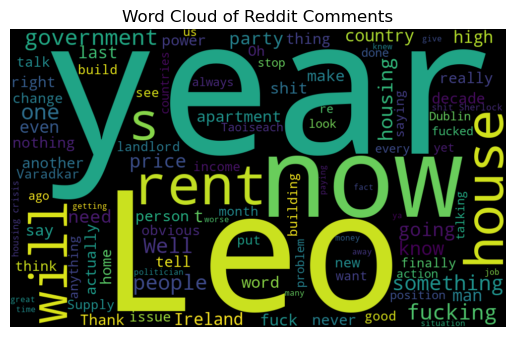

In [21]:
# Combine all comments into a single text
text = ' '.join(reddit_df['comment'])

# Generate word cloud
wordcloud = WordCloud(width=1000, height=600, max_words=100, stopwords=STOPWORDS, background_color="black").generate(text)

# Plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Reddit Comments')
plt.show()


**End of Sentiment Analysis Task**